# Expressing classical control flow in quantum programs
In the getting-started notebook, you learn how to compose a basic quantum program with only quantum gates. A quantum program should also be able to express classical control flow, such as if-else branches, for-loops and subroutines. With AutoQASM, you write control flow the same way you would do in a Python program. The Pythonic experience in expressing classical control flow makes the quantum programs more readable, and makes it easier to build more complex programs.



In [1]:
# general imports
from collections import Counter
import matplotlib.pyplot as plt

# AWS imports: Import Braket SDK modules
from braket.devices import LocalSimulator

# AutoQASM imports
import autoqasm as aq
from autoqasm.instructions import measure, h, cnot

## Subroutine
When your quantum program uses the same logic multiple times, subroutines can be a helpful tool. With subroutines, you can generate a more efficient program representation. Your programs become easier to read and reason about, and less work to maintain.

As an example, we want to prepare two Bell states, each on different qubit pair. Because the gates to prepare Bell states are the same, we can implement them as a subroutine. Similar to a quantum program, a subroutine is marked by the `@aq.subroutine` decorator. Any number of functions in your program can be marked as a quantum program with this decorator, and they can call one another. Here, we define the Bell state preparation as a subroutine.

In [2]:
@aq.subroutine
def bell(q0: int, q1: int):
    h(q0)
    cnot(q0, q1)

In `two_bell`, the subroutine is called twice to prepare Bell states on different qubit pairs.

In [3]:
@aq.main(num_qubits=4)
def two_bell():
    bell(0, 1)
    bell(2, 3)


print(two_bell.build().to_ir())

OPENQASM 3.0;
def bell(int[32] q0, int[32] q1) {
    h __qubits__[q0];
    cnot __qubits__[q0], __qubits__[q1];
}
qubit[4] __qubits__;
bell(0, 1);
bell(2, 3);


With classical control flow, sometimes the number of qubits used could be undetermined before the execution time (i.e., when program is executed on a QPU or a simulator). Therefore, AutoQASM does not know how many qubits the program may need. In cases like subroutine and using variables as qubit indices, we must define the qubit count using the keyword argument `num_qubits` in `@aq.main`.

## If-else logic branch

In this example, we demonstrate if-else logic. We use a Bell state again, but this time we prepare the state on a dynamically determined qubit pair. We measure qubit `0` and apply the Bell state preparation onto qubits `1` and `2` if the result is `1` or else `3` and `4` if the result is `0`. Finally, we measure all five qubits.

In [4]:
@aq.main(num_qubits=5)
def conditioned_bell():
    h(0)
    if measure(0):
        bell(1, 2)
    else:
        bell(3, 4)

    return measure()

Let's run the quantum program on the Braket simulator.

measurement counts:  Counter({'11100': 131, '00000': 131, '00011': 124, '10000': 114})


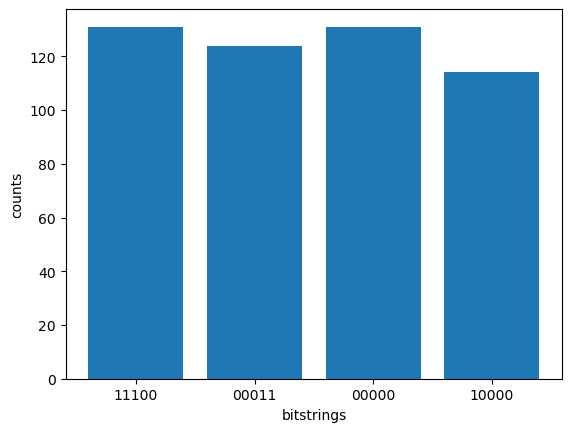

In [5]:
device = LocalSimulator("autoqasm")
result = device.run(conditioned_bell, shots=500).result()
counts = Counter(result.measurements["return_value"])
print("measurement counts: ", counts)

plt.bar(counts.keys(), counts.values())
plt.xlabel("bitstrings")
plt.ylabel("counts")
plt.show()

The simulator result shows that the Bell state is prepared on the qubit pair (1, 2) when the 0th (leftmost) qubit is measured as 1, resulting in measured bitstrings '10000' and '11100'. Otherwise, the Bell state is prepared on the qubit pair (3, 4), resulting in measured bitstrings '00000' and '00011'.

## For-loop

In this example, we demonstrate for-loop by creating many Bell states in a quantum program. Instead of writing the preparation steps explicitly, we can use a for-loop to make the program simpler and more readable. In the generated QASM script, you can see the code structure of for-loop is preserved.

In [6]:
n_bell = 3


@aq.main(num_qubits=n_bell * 2)
def multiple_bell():
    for i in aq.range(0, len(aq.qubits), 2):
        bell(i, i + 1)


print(multiple_bell.build().to_ir())

OPENQASM 3.0;
def bell(int[32] q0, int[32] q1) {
    h __qubits__[q0];
    cnot __qubits__[q0], __qubits__[q1];
}
qubit[6] __qubits__;
for int i in [0:2:6 - 1] {
    bell(i, i + 1);
}


## Summary

In this notebook, you have learned how to use AutoQASM to express classical control flow in your quantum program. AutoQASM not only enables writing program with real-time control flow based on measurement results, but also increases the readability by taking advantage of high level programming features such as for-loops and subroutines.